### Importing the Libraries

In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
tf.__version__

'2.18.0'

### Part 1 - Data Preprocessing

In [44]:
def load_and_save_data(directory_path, target_size=(128, 128)):
    # Initialize the ImageDataGenerator for on-the-fly image preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values to [0, 1]
        shear_range=0.2,  # Shear augmentation
        zoom_range=0.2,   # Zoom augmentation
        horizontal_flip=True,  # Flip images horizontally
        validation_split=0.2  # 20% for validation
    )

    # Create an instance of ImageDataGenerator for testing without augmentation
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Define the directories for the training and validation sets
    train_dir = directory_path
    test_dir = directory_path

    # Apply the data generators for training and validation
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode='grayscale',  # Use grayscale mode
        batch_size=10,
        class_mode='categorical',  # One-hot encoding for classes
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode='grayscale',  # Use grayscale mode
        batch_size=10,
        class_mode='categorical',
        subset='validation'
    )

    # Apply the test generator for evaluation
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        color_mode='grayscale',  # Use grayscale mode
        batch_size=10,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

In [45]:
dataset_path = "../dataset"  # Replace with your dataset path
train_generator, validation_generator, test_generator = load_and_save_data(dataset_path, target_size=(128, 128))


Found 3742 images belonging to 26 classes.
Found 934 images belonging to 26 classes.
Found 4676 images belonging to 26 classes.


### Part 2 - Building the CNN


In [46]:
classifier = tf.keras.models.Sequential()


#### Step 1 - Convolution


In [47]:
classifier.add(tf.keras.layers.Conv2D(filters=32,
                                     kernel_size=3, 
                                     padding="same", 
                                     activation="relu", 
                                     input_shape=[128, 128, 1]))

c:\Users\bhumi_umd\Desktop\Sign-Language-Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Step 2 - Pooling

In [48]:
classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, 
                                         strides=2, 
                                         padding='valid'))


#### Adding a second convolutional layer

In [49]:
classifier.add(tf.keras.layers.Conv2D(filters=32, 
                                      kernel_size=3, 
                                      padding="same", 
                                      activation="relu"))

classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, 
                                         strides=2, 
                                         padding='valid'))

#### Step 3 - Flattening


In [50]:
classifier.add(tf.keras.layers.Flatten())


#### Step 4 - Full Connection


In [54]:
classifier.add(tf.keras.layers.Dense(units=128, 
                                     activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.40))
classifier.add(tf.keras.layers.Dense(units=96, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.40))
classifier.add(tf.keras.layers.Dense(units=64, activation='relu'))
classifier.add(tf.keras.layers.Dense(units=26, activation='softmax')) # softmax for more than 2


### Part 3 - Training the CNN


#### Compiling the CNN


In [55]:
classifier.compile(optimizer = 'adam', 
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

classifier.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 27)             │         1,755 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,248,213 (16.21 MB)

 Trainable params: 4,248,213 (16.21 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the CNN on the Training set and evaluating it on the Test set

In [58]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model2.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = classifier.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0409 - loss: 3.2591
Epoch 1: val_loss improved from inf to 3.25832, saving model to best_model2.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - accuracy: 0.0409 - loss: 3.2591 - val_accuracy: 0.0385 - val_loss: 3.2583 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.0365 - loss: 3.2594
Epoch 3: val_loss improved from 3.25832 to 3.25814, saving model to best_model2.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - accuracy: 0.0364 - loss: 3.2594 - val_accuracy: 0.0385 - val_loss: 3.2581 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 75us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.0349 - loss: 3.2589
Epoch 5: val_loss improved from 3.25814 to

In [63]:
# Evaluate the model on the test data
test_loss, test_accuracy = classifier.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

468/468 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.0391 - loss: 3.2582
Test Loss: 3.258125066757202
Test Accuracy: 0.03849443793296814


In [60]:
best_training_accuracy = max(history.history['accuracy'])
best_validation_accuracy = max(history.history['val_accuracy'])

print(f"Best Training Accuracy: {best_training_accuracy}")
print(f"Best Validation Accuracy: {best_validation_accuracy}")

Best Training Accuracy: 0.03687867522239685
Best Validation Accuracy: 0.03854389861226082


#### Saving the Model

In [61]:
model_json = classifier.to_json()
with open("model_new2.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')

classifier.save_weights('model_new2.weights.h5')
print('Weights saved')

Model Saved
Weights saved


### Part 4: Plotting training/validation accuracy and loss

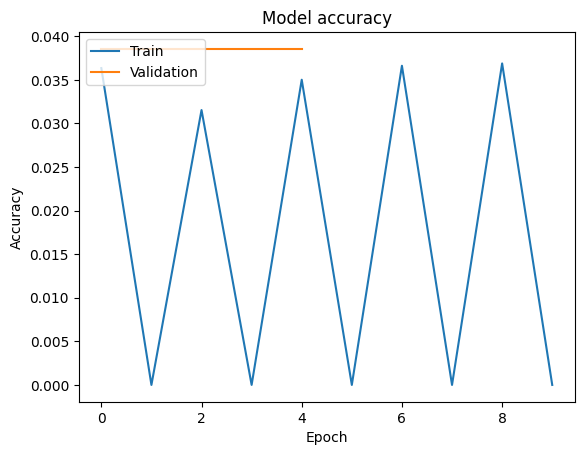

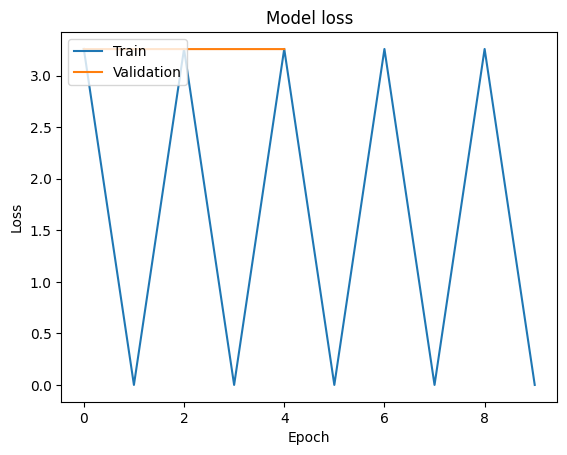

In [64]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Part 5: Evaluate model using test generator

In [65]:
y_pred = classifier.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

468/468 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step


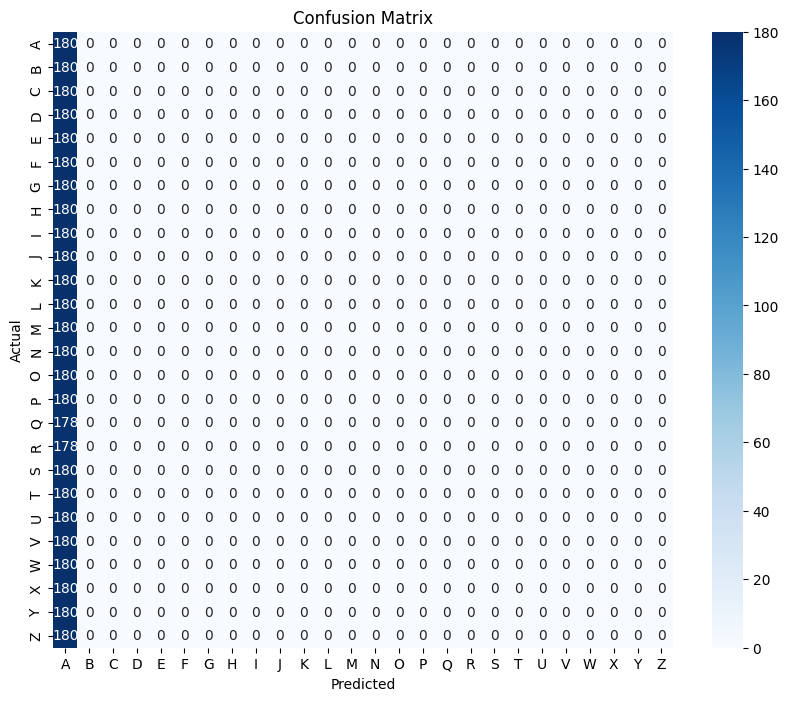

In [66]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [67]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.04      1.00      0.07       180
           1       0.00      0.00      0.00       180
           2       0.00      0.00      0.00       180
           3       0.00      0.00      0.00       180
           4       0.00      0.00      0.00       180
           5       0.00      0.00      0.00       180
           6       0.00      0.00      0.00       180
           7       0.00      0.00      0.00       180
           8       0.00      0.00      0.00       180
           9       0.00      0.00      0.00       180
          10       0.00      0.00      0.00       180
          11       0.00      0.00      0.00       180
          12       0.00      0.00      0.00       180
          13       0.00      0.00      0.00       180
          14       0.00      0.00      0.00       180
          15       0.00      0.00      0.00       180
          16       0.00      0.00      0.00       178
          17       0.00    

c:\Users\bhumi_umd\Desktop\Sign-Language-Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bhumi_umd\Desktop\Sign-Language-Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bhumi_umd\Desktop\Sign-Language-Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [68]:
# Evaluate the model on the validation set
loss, accuracy = classifier.evaluate(validation_generator, steps=len(validation_generator))
print(f"Validation accuracy: {accuracy:.4f}")
print(f"Validation loss: {loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.0351 - loss: 3.2580
Validation accuracy: 0.0385
Validation loss: 3.2581
